<a href="https://colab.research.google.com/github/harshbansal7/AQI-Analysis-SARIMAX/blob/main/AQI_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [479]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [480]:
from google.colab import drive
drive.mount('/content/drive')

city_day = pd.read_csv('/content/drive/MyDrive/city_day.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [481]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [482]:
# Extracting a specific state's data

state_name = 'Delhi'
state_data = city_day[city_day['City']==state_name]
state_data.set_index('Date',inplace=True, drop = False)

In [483]:
# Converting required data into a Pandas dataframe.

final_data = pd.DataFrame(index=state_data.index, columns = ['AQI'])
final_data['AQI'] = state_data['AQI']
final_data=final_data.astype('float64')
# final_data[val] = final_data[val].fillna(final_data[val].mean(axis=0))
final_data.index = pd.to_datetime(final_data.index)
final_data.head()

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0


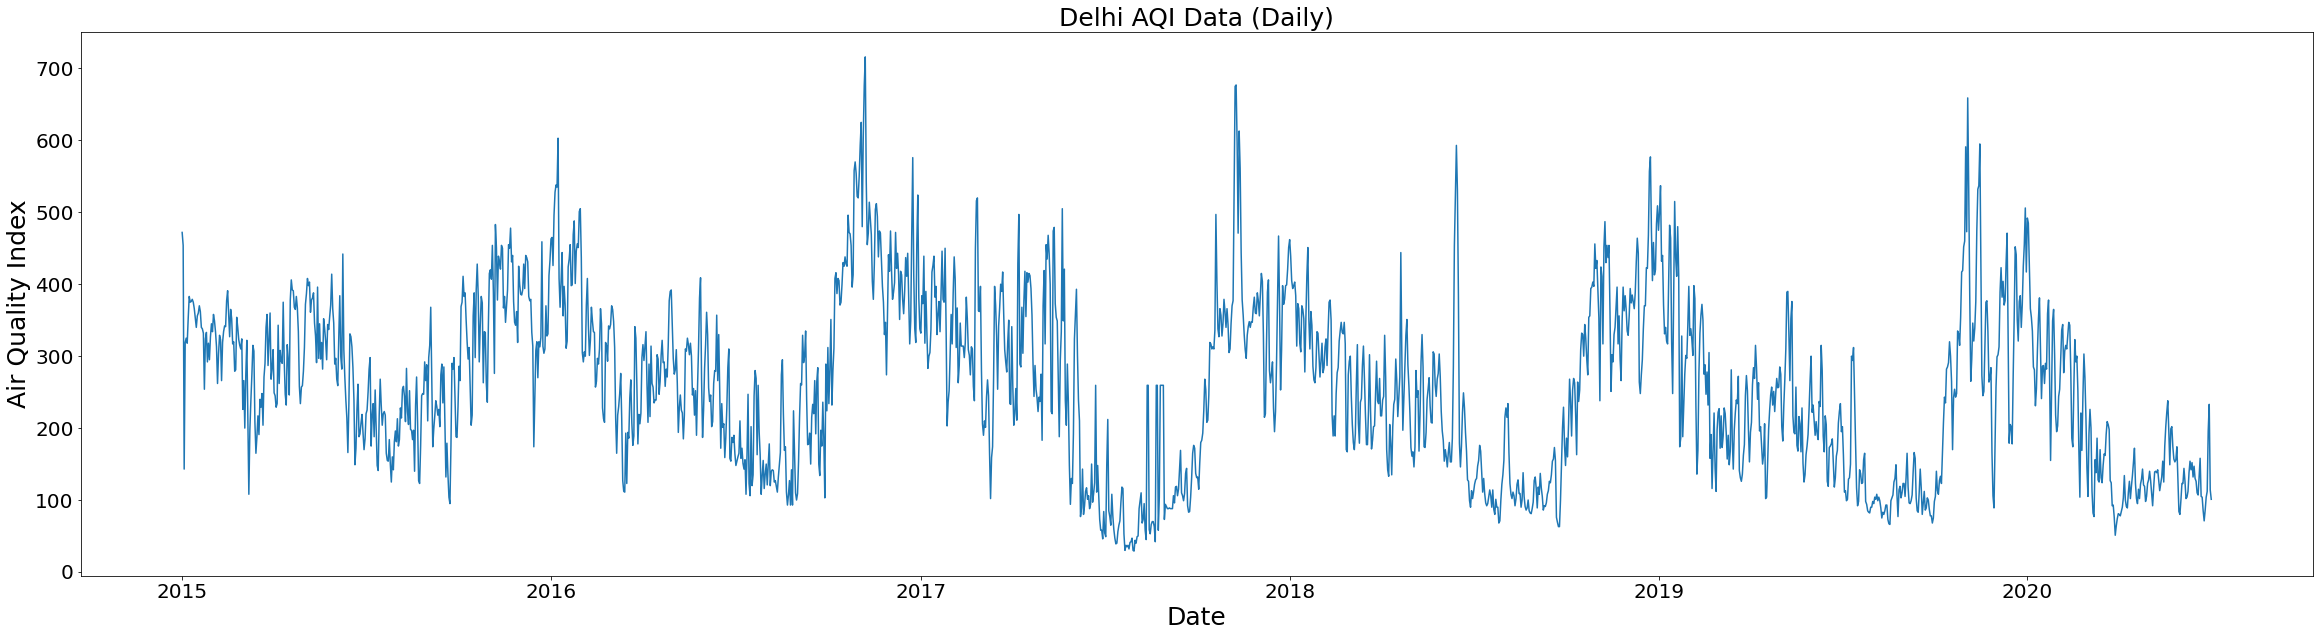

In [590]:
# Plotting all the datapoints using MatPlotLib
fig = plt.figure(figsize = (40, 10))
plt.plot(final_data.index,final_data.AQI)
title = state_name + ' AQI Data (Daily)'
plt.title(title, fontsize = 25)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Air Quality Index", fontsize = 25)
plt.tick_params(labelsize=20)
plt.savefig("Data.png",dpi=300)
plt.show()

<Figure size 2160x720 with 0 Axes>

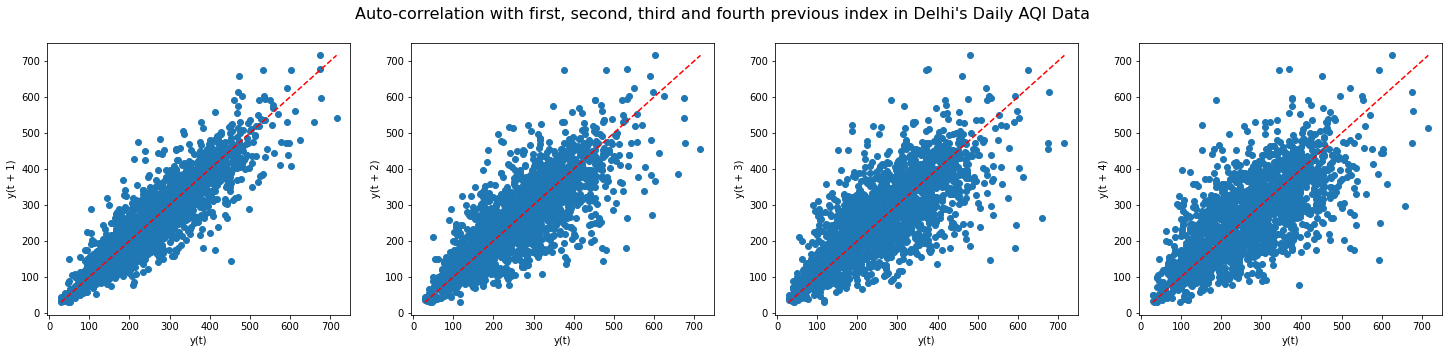

In [485]:
# Plotting Autocorrelation Scatterplots
from pandas.plotting import lag_plot
fig = plt.figure(figsize = (30, 10))

fig, ax_ = plt.subplots(1, 4, figsize = (25, 5))
aqi_serie = final_data.AQI
for i in range(4):
    
    lag_plot((aqi_serie), lag = i+1, ax = ax_[i]);
    ax_[i].plot([min(aqi_serie), max(aqi_serie)], [min(aqi_serie), max(aqi_serie)],'--', color = 'red' )

fig.suptitle('Auto-correlation with first, second, third and fourth previous index in ' + state_name + '\'s Daily AQI Data', fontsize = 16);
# plt.savefig("Data.png", dpi=300)

In [486]:
# Making data continuous using interpolation through mean, so that it can be used in further time series forecasting

final_data['AQI'] = final_data['AQI'].fillna(final_data['AQI'].mean(axis=0))
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     2009 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


<Figure size 7200x2160 with 0 Axes>

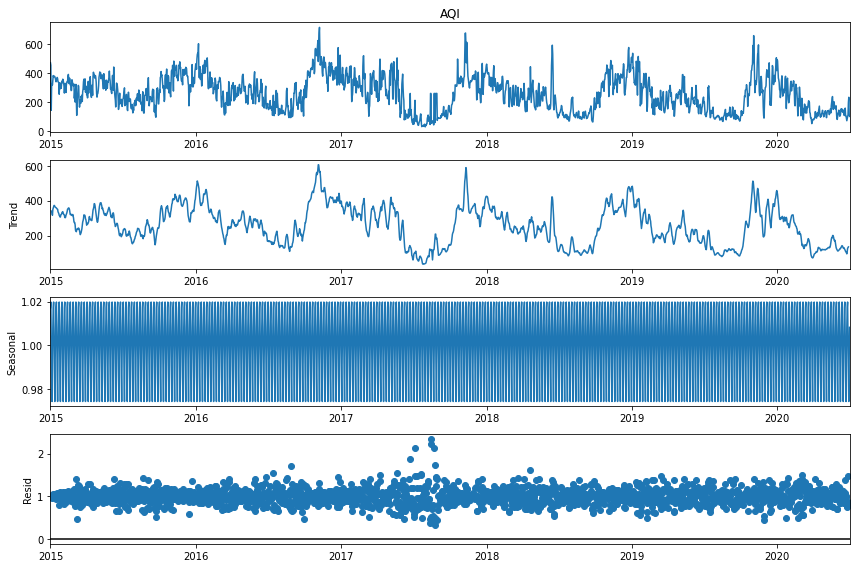

In [487]:
# Seasonal Decompose using statsmodels library.

from statsmodels.tsa.seasonal import seasonal_decompose

AQI_data = final_data['AQI']
fig = plt.figure(figsize = (100,30))
result = seasonal_decompose(AQI_data, model='multiplicative')
result.plot();

In [488]:
# RESAMPLING DATA TO MONTHLY FORMAT
# MS is code for resampling Monthly

seasonal_data = final_data
seasonal_data = seasonal_data.resample(rule='MS').mean()
seasonal_data

,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
...,...
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161


<Figure size 2160x2160 with 0 Axes>

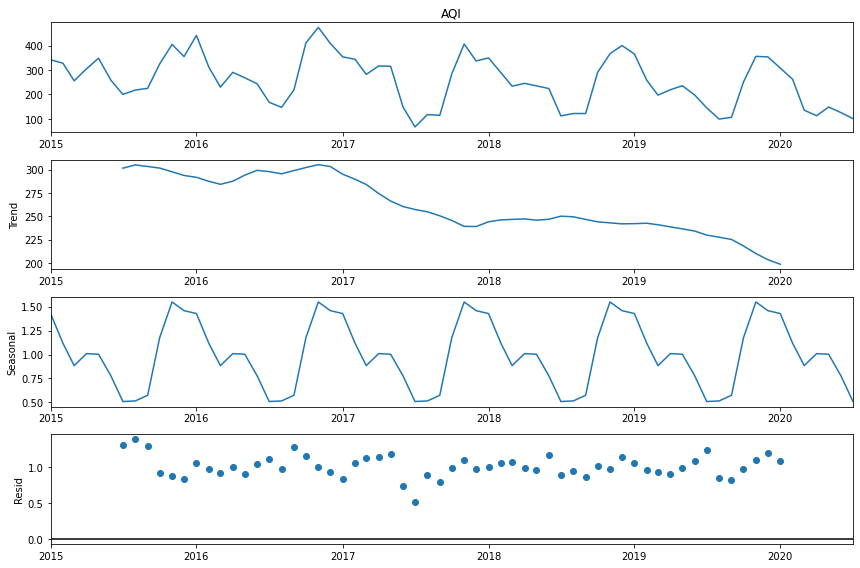

In [489]:
monthly_data = seasonal_data['AQI']
fig = plt.figure(figsize = (30,30))
result = seasonal_decompose(monthly_data, model='multiplicative')
result.plot();

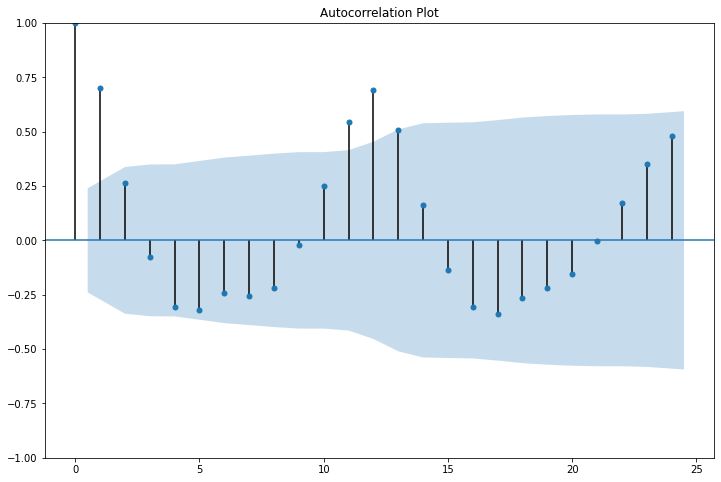

In [490]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(monthly_data, lags=24, title="Autocorrelation Plot")
plt.savefig("Data.png",dpi=300)
plt.show()

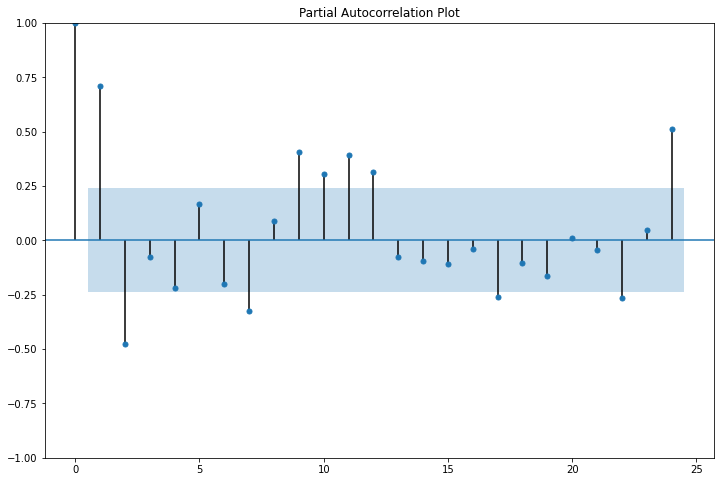

In [491]:
# AUTOCORRELATION PLOT (24 Months rather than 12 for reference)
fig = tsaplots.plot_pacf(monthly_data, lags=24, title="Partial Autocorrelation Plot")
plt.savefig("Data.png",dpi=300)
plt.show()

In [492]:
# Splitting Before and After Lockdown values

AQI_beforeLockdown = monthly_data['2015-01-01':'2020-03-25']
AQI_afterLockdown = monthly_data['2020-03-26':'2020-07-01']

**MODELS COME INTO PLAY**

In [493]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [494]:
# Finding Parameters of the ARIMA Model using Auto_Arima
auto_arima(y=monthly_data,start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [495]:
# TEST TRAIN SPLIT
train_size = int(len(AQI_beforeLockdown) * 0.8)
X_train = AQI_beforeLockdown[:train_size+1] #from 2015-2018
X_test = AQI_beforeLockdown[train_size+1:len(monthly_data)-1]# july 2018-june 2019

In [496]:
X_test

Date
2019-04-01    219.400000
2019-05-01    235.838710
2019-06-01    197.766667
2019-07-01    145.096774
2019-08-01     99.290323
2019-09-01    106.533333
2019-10-01    251.000000
2019-11-01    356.100000
2019-12-01    353.903226
2020-01-01    308.451613
2020-02-01    262.137931
2020-03-01    135.838710
Freq: MS, Name: AQI, dtype: float64

In [497]:
# TRAINING FINAL MODEL

model=SARIMAX(X_train,order=(1,0,0),seasonal_order=(1,0,1,12),)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   51
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -275.756
Date:                              Fri, 13 Jan 2023   AIC                            559.512
Time:                                      13:42:32   BIC                            567.240
Sample:                                  01-01-2015   HQIC                           562.465
                                       - 03-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8702      0.073     11.873      0.000       0.727       1.014
ar.S.L12       0.9990      0.079     12.592      0.000       0.844       1.155
ma.S.L12      -0.9217      3.081     -0.299      0.765      -6.960       5.116
sigma2      1600.9545   4800.112      0.334      0.739   -7807.092     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.54   Prob(JB):                         0.99
Heteroskedasticity (H):               0.82   Skew:                             0.03
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [498]:
# Making Predictions on Test Dataset
predictionsX = results.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1], typ='levels').rename('Predictions')

Text(0.5, 0, 'Date')

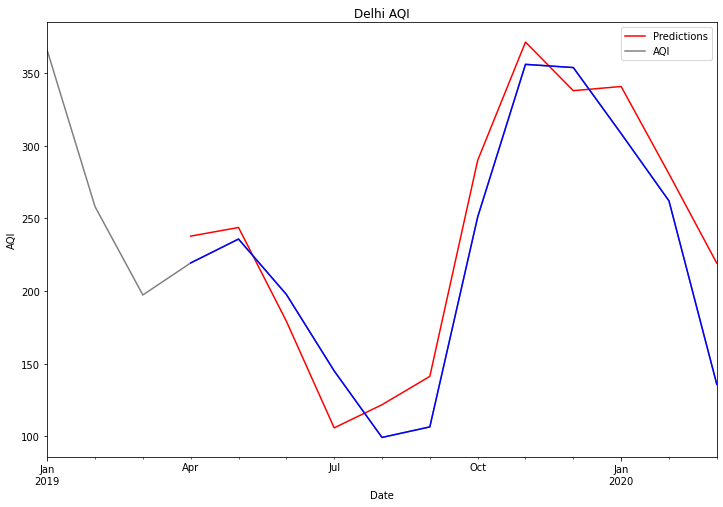

In [499]:
# Visualizing Results
predictionsX = results.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1], typ='levels').rename('Predictions')
predictionsX.plot(legend=True, color = 'red')
AQI_2020 = monthly_data['2019-01-01':'2020-03-30']
AQI_2020.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI",color = 'gray');
X_test.plot(color = 'blue');
plt.ylabel("AQI")
plt.xlabel("Date")

In [500]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error,mean_poisson_deviance,mean_gamma_deviance
import math
RMSE=np.sqrt(mean_squared_error(predictionsX,X_test))
print('Root Mean Squared Error: ', RMSE)
print('Mean AQI:',X_test.mean())
forecast_errors = [X_test[i]-predictionsX[i] for i in range(len(X_test))]
bias = sum(forecast_errors) * 1.0/len(X_test)
print('Bias: %f' % bias)
mse = mean_squared_error(X_test, predictionsX)
print('MSE: '+str(mse))
mae = mean_absolute_error(X_test, predictionsX)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(X_test, predictionsX))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictionsX - X_test)/np.abs(X_test))
print('MAPE: '+str(mape))
r2score=r2_score(X_test, predictionsX)
print('r2score: '+str(r2score))
explainedVariance_score=explained_variance_score(X_test, predictionsX)
print('explainedVariance_score: '+str(explainedVariance_score))
me=max_error(X_test, predictionsX)
print('me: '+str(me))
mpd=mean_poisson_deviance(X_test, predictionsX)
print('mpd: '+str(mpd))
mgd=mean_gamma_deviance(X_test, predictionsX)
print('mgd: '+str(mgd))

Root Mean Squared Error:  34.585322813927355
Mean AQI: 222.6131071560994
Bias: -16.571768
MSE: 1196.144554143564
MAE: 28.833258561547996
RMSE: 34.585322813927355
MAPE: 0.17231931667649134
r2score: 0.8365481910075254
explainedVariance_score: 0.8740751830408704
me: 83.35957502052324
mpd: 6.535708782736457
mgd: 0.03952775705271113


Text(0.5, 0, 'Date')

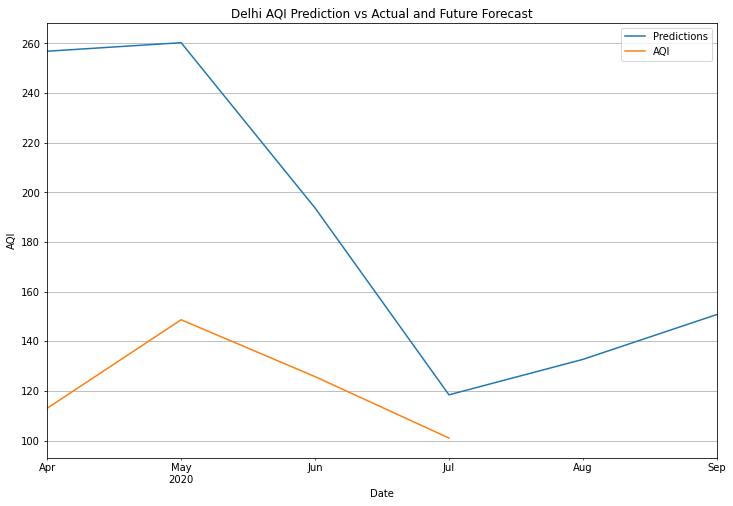

In [501]:
# Graph for Actual vs Predicted in Covid
after_covid_months = monthly_data[63:]
predictions = results.predict(start=63, end=68, typ='levels').rename('Predictions')
predictions.plot(legend=True)
after_covid_months.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI Prediction vs Actual and Future Forecast");
plt.ylabel("AQI")
plt.xlabel("Date")

In [502]:
city_name = ['Delhi', 'Hyderabad', 'Bengaluru', 'Chennai']
city_day['Date'] = pd.to_datetime(city_day['Date'])
df = pd.DataFrame(columns=['City', 'Year', 'Mean'])

for city in city_name:
  for i in range(2015,2021):
    blr = city_day[(city_day.AQI.notnull()) & (city_day.City == city)][['Date','City','AQI']]
    blr_marchtojuly = blr[(blr["Date"].map(lambda x: x.month in [3,4,5,6,7])) & (blr["Date"].map(lambda x: x.year in [i])) & (blr["Date"].map(lambda x: x >= pd.to_datetime(f'25-03-{x.year}')))]
    # print('Mean AQI for March to July for City '+city+ ' - Year ' + str(i) + ' is ' + str(blr_marchtojuly.mean()))
    df = df.append({'City': city, 'Year': i, 'Mean': float(blr_marchtojuly.mean())}, ignore_index=True)

In [503]:
df

,City,Year,Mean
0,Delhi,2015,280.170543
1,Delhi,2016,242.234375
2,Delhi,2017,215.453125
3,Delhi,2018,205.906977
4,Delhi,2019,199.744186
5,Delhi,2020,125.272727
6,Hyderabad,2015,126.176471
7,Hyderabad,2016,127.796875
8,Hyderabad,2017,101.341085
9,Hyderabad,2018,81.015504


City
Bengaluru     92.408845
Chennai      114.950576
Delhi        228.701841
Hyderabad    103.723351
Name: Mean, dtype: float64


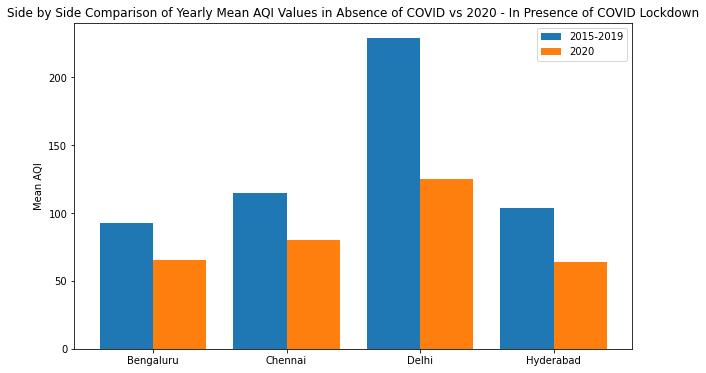

In [504]:
# Group the data by city and calculate the mean AQI value for 2015-2019
mean_2015_2019 = df[df['Year'] != 2020].sort_values('City')
mean_2015_2019 = mean_2015_2019.groupby('City')['Mean'].mean()
print(mean_2015_2019)
# Extract the data for 2020
df_2020 = df[df['Year'] == 2020].sort_values('City')

# Set the x-axis labels
x_labels = df_2020['City'].tolist()

# Set the bar width
bar_width = 0.4

# Calculate the x-axis positions for the bars
x_2015_2019 = [x for x in range(len(x_labels))]
x_2020 = [x + bar_width for x in x_2015_2019]
plt.figure(figsize=(10,6))
plt.bar(x_2015_2019, mean_2015_2019, width=bar_width, label='2015-2019')
plt.bar(x_2020, df_2020['Mean'], width=bar_width, label='2020')
plt.xticks([x + bar_width/2 for x in x_2015_2019], x_labels)
plt.ylabel('Mean AQI')
plt.title('Side by Side Comparison of Yearly Mean AQI Values in Absence of COVID vs 2020 - In Presence of COVID Lockdown')
plt.legend()
plt.show()


Text(0.5, 0, 'Date')

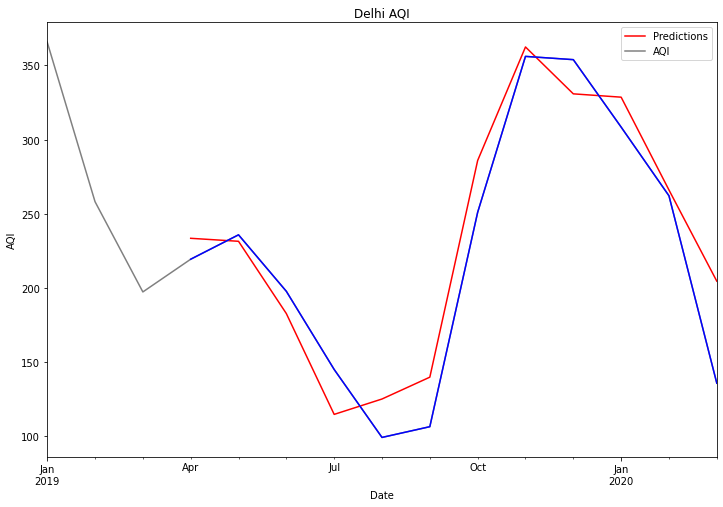

In [505]:
# Implementing the ETS Model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
plt.rcParams["figure.figsize"] = (12, 8)

train_size = int(len(AQI_beforeLockdown) * 0.8)
X_train = AQI_beforeLockdown[:train_size+1] #from 2015-2018
X_test = AQI_beforeLockdown[train_size+1:len(monthly_data)-1]# july 2018-june 2019

model = ETSModel(
    X_train,
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    seasonal_periods=12,
)

fit = model.fit()

# Visualizing Results
predictionsX = fit.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1]).rename('Predictions')
predictionsX.plot(legend=True, color = 'red')
AQI_2020 = monthly_data['2019-01-01':'2020-03-30']
AQI_2020.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI",color = 'gray');
X_test.plot(color = 'blue');
plt.ylabel("AQI")
plt.xlabel("Date")


In [506]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error,mean_poisson_deviance,mean_gamma_deviance
import math
RMSE=np.sqrt(mean_squared_error(predictionsX,X_test))
print('Root Mean Squared Error: ', RMSE)
print('Mean AQI:',X_test.mean())
forecast_errors = [X_test[i]-predictionsX[i] for i in range(len(X_test))]
bias = sum(forecast_errors) * 1.0/len(X_test)
print('Bias: %f' % bias)
mse = mean_squared_error(X_test, predictionsX)
print('MSE: '+str(mse))
mae = mean_absolute_error(X_test, predictionsX)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(X_test, predictionsX))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictionsX - X_test)/np.abs(X_test))
print('MAPE: '+str(mape))
r2score=r2_score(X_test, predictionsX)
print('r2score: '+str(r2score))
explainedVariance_score=explained_variance_score(X_test, predictionsX)
print('explainedVariance_score: '+str(explainedVariance_score))
me=max_error(X_test, predictionsX)
print('me: '+str(me))
mpd=mean_poisson_deviance(X_test, predictionsX)
print('mpd: '+str(mpd))
mgd=mean_gamma_deviance(X_test, predictionsX)
print('mgd: '+str(mgd))

Root Mean Squared Error:  28.991278387677195
Mean AQI: 222.6131071560994
Bias: -11.236955
MSE: 840.4942225517989
MAE: 23.348376324270344
RMSE: 28.991278387677195
MAPE: 0.1458322025270381
r2score: 0.885147409108777
explainedVariance_score: 0.9024019476572068
me: 68.7625694673776
mpd: 4.805454563594566
mgd: 0.029997024366640312


Text(0.5, 0, 'Date')

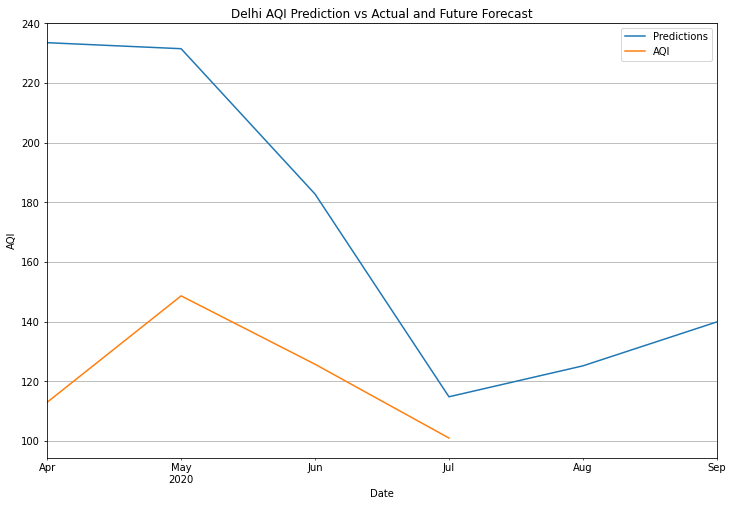

In [507]:
# Graph for Actual vs Predicted in Covid
after_covid_months = monthly_data[63:]
predictions = fit.predict(start=63, end=68).rename('Predictions')
predictions.plot(legend=True)
after_covid_months.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI Prediction vs Actual and Future Forecast");
plt.ylabel("AQI")
plt.xlabel("Date")

In [508]:
AQI_beforeLockdown

Date
2015-01-01    342.290323
2015-02-01    327.928571
2015-03-01    256.064516
2015-04-01    305.266667
2015-05-01    348.580645
                 ...    
2019-11-01    356.100000
2019-12-01    353.903226
2020-01-01    308.451613
2020-02-01    262.137931
2020-03-01    135.838710
Freq: MS, Name: AQI, Length: 63, dtype: float64

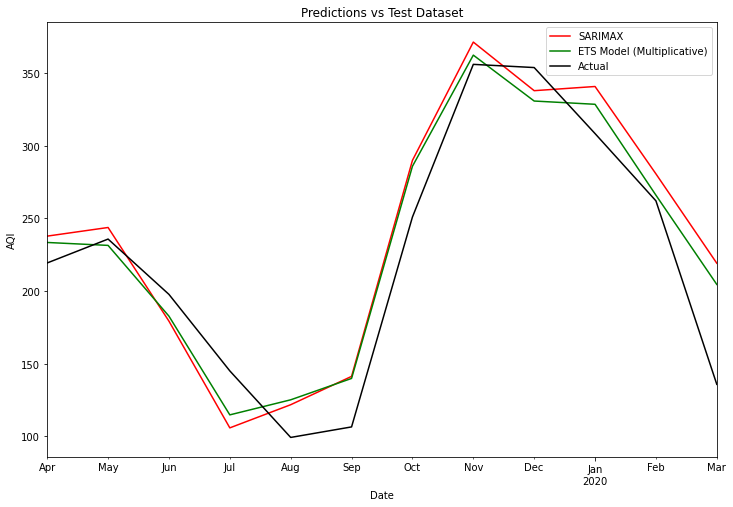

In [509]:
predictionsFit = fit.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1]).rename('Predictions')
predictionsX = results.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1], typ='levels').rename('Predictions')

# Concatenate all the predictions and test data together
predictions = pd.concat([predictionsX, predictionsFit, X_test], axis=1)

# Rename the columns
predictions.columns = ['SARIMAX', 'ETS Model (Multiplicative)', 'Actual']

# Plot the data
ax = predictions.plot(figsize=(12,8), grid=False, title="Predictions vs Test Dataset", color=['red', 'green', 'black'])
# Add labels and legend
plt.ylabel("AQI")
plt.xlabel("Date")
plt.legend()

# Show the plot
plt.savefig("Data.png",dpi=300)
plt.show()


In [510]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [527]:
AQI_beforeLockdown

Date
2015-01-01    342.290323
2015-02-01    327.928571
2015-03-01    256.064516
2015-04-01    305.266667
2015-05-01    348.580645
                 ...    
2019-11-01    356.100000
2019-12-01    353.903226
2020-01-01    308.451613
2020-02-01    262.137931
2020-03-01    135.838710
Freq: MS, Name: AQI, Length: 63, dtype: float64

In [555]:
AQI_beforeLockdown
train_size = int(len(AQI_beforeLockdown) * 0.8)
X_train = AQI_beforeLockdown[:train_size+1] #from 2015-2018
X_test = AQI_beforeLockdown[train_size+1:len(monthly_data)-1]# july 2018-june 2019

df = pd.DataFrame(X_train)

new_df = pd.DataFrame(columns = ['ds','y'])

new_df['ds'] = df.index
new_df['y']= df['AQI'].values

new_df

,ds,y
0,2015-01-01,342.290323
1,2015-02-01,327.928571
2,2015-03-01,256.064516
3,2015-04-01,305.266667
4,2015-05-01,348.580645
5,2015-06-01,258.333333
6,2015-07-01,200.290323
7,2015-08-01,218.064516
8,2015-09-01,225.300000
9,2015-10-01,325.000000


In [557]:
from prophet import Prophet
m = Prophet(seasonality_mode='multiplicative')
m.fit(new_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn3sutzk0/2w1me4eo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn3sutzk0/h3wrs8a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32962', 'data', 'file=/tmp/tmpn3sutzk0/2w1me4eo.json', 'init=/tmp/tmpn3sutzk0/h3wrs8a8.json', 'output', 'file=/tmp/tmpn3sutzk0/prophet_modelbrmwhnt8/prophet_model-20230113140745.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:07:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [559]:
X_test

Date
2019-04-01    219.400000
2019-05-01    235.838710
2019-06-01    197.766667
2019-07-01    145.096774
2019-08-01     99.290323
2019-09-01    106.533333
2019-10-01    251.000000
2019-11-01    356.100000
2019-12-01    353.903226
2020-01-01    308.451613
2020-02-01    262.137931
2020-03-01    135.838710
Freq: MS, Name: AQI, dtype: float64

In [573]:
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat']]
forecast.set_index('ds',inplace=True, drop = True)
forecast

df_last_3 = forecast.tail(12)

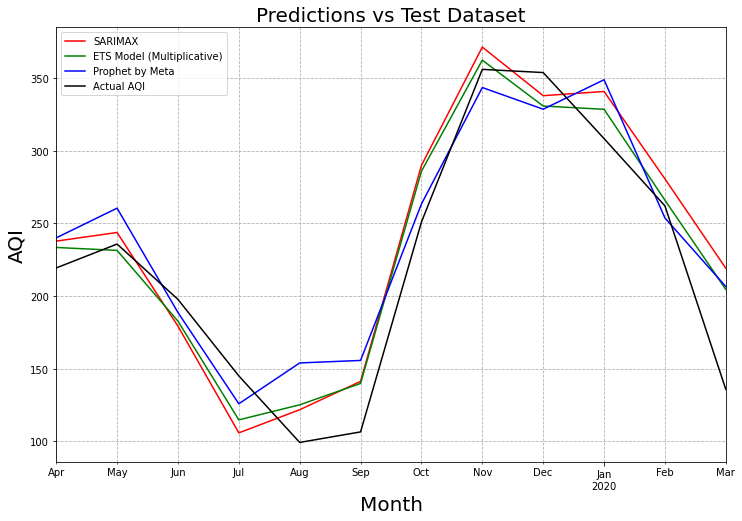

In [624]:
predictionsFit = fit.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1]).rename('Predictions')
predictionsX = results.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1], typ='levels').rename('Predictions')

# Concatenate all the predictions and test data together
predictions = pd.concat([predictionsX, predictionsFit, df_last_3, X_test], axis=1)

# Rename the columns
predictions.columns = ['SARIMAX', 'ETS Model (Multiplicative)', 'Prophet by Meta', 'Actual AQI']

# Plot the data
ax = predictions.plot(figsize=(12,8), grid=False, title="Predictions vs Test Dataset", color=['red', 'green', 'blue', 'black'])
# Add labels and legend
plt.ylabel("AQI", fontsize = 20)
plt.xlabel("Month", fontsize = 20)
plt.title("Predictions vs Test Dataset", fontsize = 20)
plt.legend()
plt.grid(axis='both', which='both', linestyle='--')
plt.savefig("Data.png",dpi=300)
# Show the plot
plt.show()


In [578]:
y_pred = df_last_3['yhat']

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error,mean_poisson_deviance,mean_gamma_deviance
import math
RMSE=np.sqrt(mean_squared_error(y_pred,X_test))
print('Root Mean Squared Error: ', RMSE)
print('Mean AQI:',X_test.mean())
forecast_errors = [X_test[i]-y_pred[i] for i in range(len(X_test))]
bias = sum(forecast_errors) * 1.0/len(X_test)
print('Bias: %f' % bias)
mse = mean_squared_error(X_test, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(X_test, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(X_test, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - X_test)/np.abs(X_test))
print('MAPE: '+str(mape))
r2score=r2_score(X_test, y_pred)
print('r2score: '+str(r2score))
explainedVariance_score=explained_variance_score(X_test, y_pred)
print('explainedVariance_score: '+str(explainedVariance_score))
me=max_error(X_test, y_pred)
print('me: '+str(me))
mpd=mean_poisson_deviance(X_test, y_pred)
print('mpd: '+str(mpd))
mgd=mean_gamma_deviance(X_test, y_pred)
print('mgd: '+str(mgd))

Root Mean Squared Error:  34.83927630532531
Mean AQI: 222.6131071560994
Bias: -16.558040
MSE: 1213.775173478802
MAE: 28.939483455024344
RMSE: 34.83927630532531
MAPE: 0.18580937957247126
r2score: 0.8341389866901879
explainedVariance_score: 0.8716038317352277
me: 70.74810880824862
mpd: 6.910935217987266
mgd: 0.04284335393624694


In [581]:
future = m.make_future_dataframe(periods=18,freq='MS')
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat']]
forecast.set_index('ds',inplace=True, drop = True)
forecast

df_last_4 = forecast.tail(6)

Text(0.5, 0, 'Date')

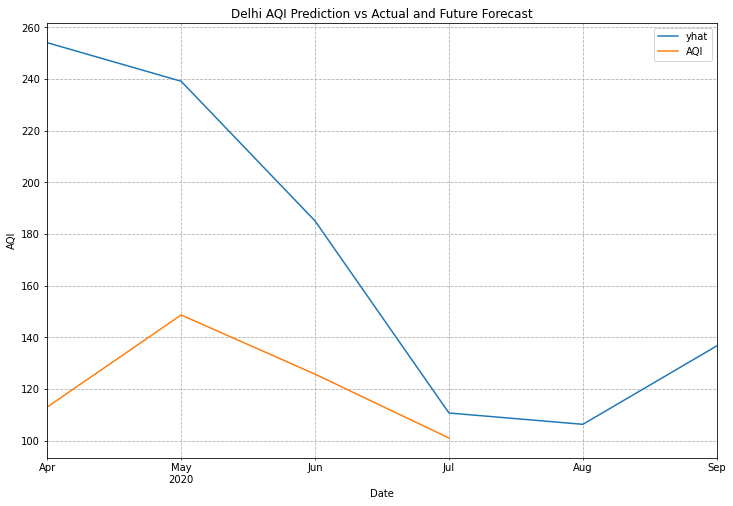

In [612]:
after_covid_months = monthly_data[63:]
df_last_4.plot(legend=True)
after_covid_months.plot(legend=True,figsize=(12,8),grid=False,title="Delhi AQI Prediction vs Actual and Future Forecast");
plt.ylabel("AQI")
plt.grid(axis='both', which='both', linestyle='--')
plt.xlabel("Date")

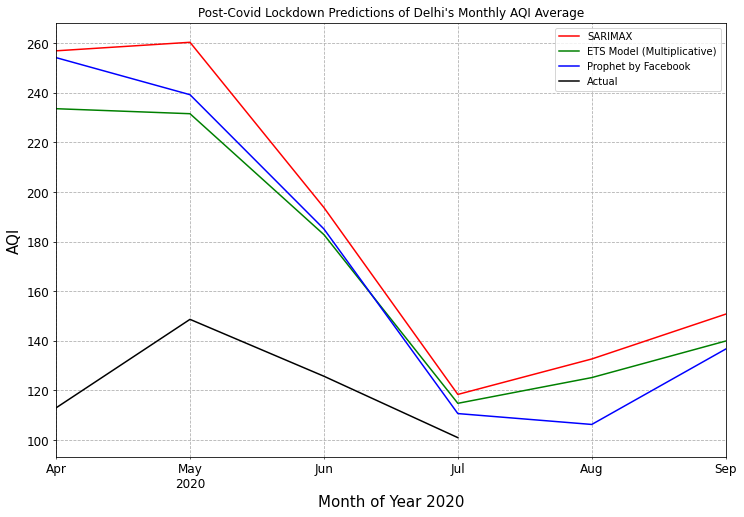

In [625]:
predictionsFitX = fit.predict(start=63, end=68).rename('Predictions')
predictionsXX = results.predict(start=63, end=68, typ='levels').rename('Predictions')

# Concatenate all the predictions and test data together
predictions = pd.concat([predictionsXX, predictionsFitX, df_last_4, after_covid_months], axis=1)

# Rename the columns
predictions.columns = ['SARIMAX', 'ETS Model (Multiplicative)', 'Prophet by Facebook', 'Actual']

# Plot the data
ax = predictions.plot(figsize=(12,8), grid=True, title="Post-Covid Lockdown Predictions of Delhi's Monthly AQI Average", fontsize = 12, color=['red', 'green', 'blue', 'black'])
# Add labels and legend
plt.ylabel("AQI", fontsize = 15)
plt.xlabel("Month of Year 2020", fontsize = 15)
plt.legend()
plt.grid(axis='both', which='both', linestyle='--')
plt.savefig("Data.png",dpi=300)
# Show the plot
plt.show()


In [626]:
predictionsFitX

2020-04-01    233.500023
2020-05-01    231.483289
2020-06-01    182.771840
2020-07-01    114.824893
2020-08-01    125.187866
2020-09-01    139.907380
Freq: MS, Name: Predictions, dtype: float64